<a href="https://colab.research.google.com/github/akashsmu/Time_series_in_Stock_Prediction-/blob/master/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 2.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np 
import pandas as pd 
import os
import pandas_datareader as web
from numpy import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import datetime
warnings.filterwarnings('ignore')
from pandas.util.testing import assert_frame_equal

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
df=web.data.get_data_yahoo('IBM',start='2012-01-01' ,end='2020-06-22')
df= df.reset_index()

print(df.shape)
print(df.columns)

df.tail()

(2131, 7)
Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')


,Date,High,Low,Open,Close,Volume,Adj Close
2126,2020-06-16,127.500000,123.160004,125.000000,125.150002,5606700.0,123.532539
2127,2020-06-17,126.250000,123.400002,125.830002,124.150002,3154200.0,122.545464
2128,2020-06-18,124.400002,122.330002,123.000000,124.160004,2865400.0,122.555336
2129,2020-06-19,126.820000,122.250000,126.169998,122.470001,8099000.0,120.887177
2130,2020-06-22,122.500000,120.529999,122.120003,121.070000,4773500.0,119.505264


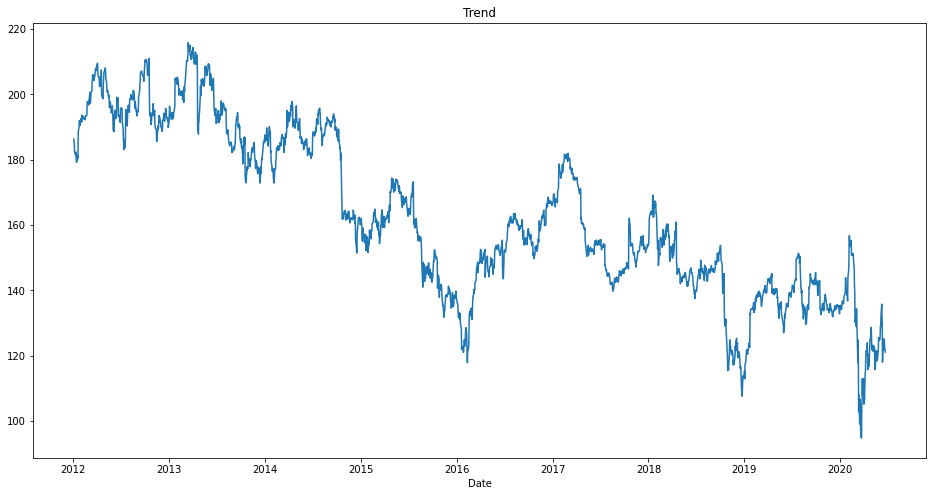

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Date'],df['Close'])
plt.title('Trend')
plt.xlabel('Date')
plt.show()

In [ ]:
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Close'])
dfoutput = pd.Series(test_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in test_result[4].items():
  dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                   -1.300307
p-value                           0.629032
#Lags Used                       25.000000
Number of Observations Used    2105.000000
Critical Value (1%)              -3.433460
Critical Value (5%)              -2.862914
Critical Value (10%)             -2.567501
dtype: float64


In [ ]:
#H0: It is non stationary
#H1: It is stationary

def adfuller_test(close):
  result = adfuller(close)
  labels = ['ADF Test Statistics','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result,labels):
    print(label+' : '+str(value))
  if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis(H0), reject the null hypothesis,i.e. data is stationary")
  else:
    print("Weak evidence against the null hypothesis(H0), means accept the null hypothesis, i.e. data is non stationary")

In [ ]:
adfuller_test(df['Close'])

ADF Test Statistics : -1.3003066746723548
p-value : 0.6290319979678389
#Lags Used : 25
Number of Observations Used : 2105
Weak evidence against the null hypothesis(H0), means accept the null hypothesis, i.e. data is non stationary


In [ ]:
df['Close_shift'] = df['Close'] - df['Close'].shift(1)
df['Close_shift'] = df['Close_shift'].fillna(method='bfill')
df['Close_shift']

0      -0.760010
1      -0.760010
2      -0.879990
3      -2.120010
4      -0.949997
          ...   
2126    3.500000
2127   -1.000000
2128    0.010002
2129   -1.690002
2130   -1.400002
Name: Close_shift, Length: 2131, dtype: float64

In [ ]:
test_result = adfuller_test(df['Close_shift'])
test_result

ADF Test Statistics : -11.277214272433923
p-value : 1.4863375816573725e-20
#Lags Used : 24
Number of Observations Used : 2106
Strong evidence against the null hypothesis(H0), reject the null hypothesis,i.e. data is stationary


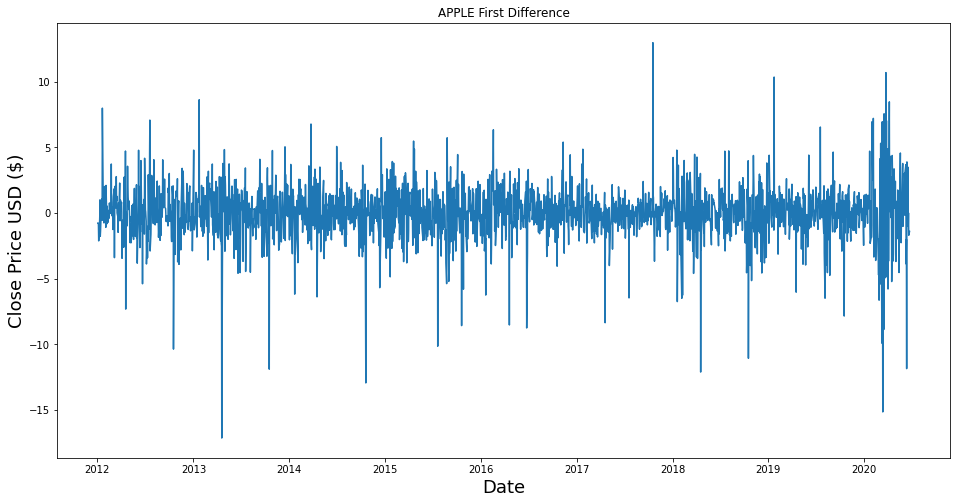

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Date'],df['Close_shift'])
plt.title("APPLE First Difference")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

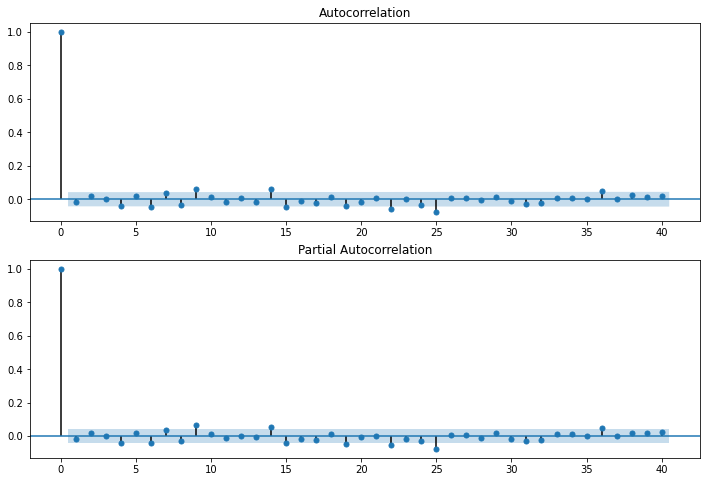

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Close_shift'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Close_shift'].iloc[1:],lags=40,ax=ax2)

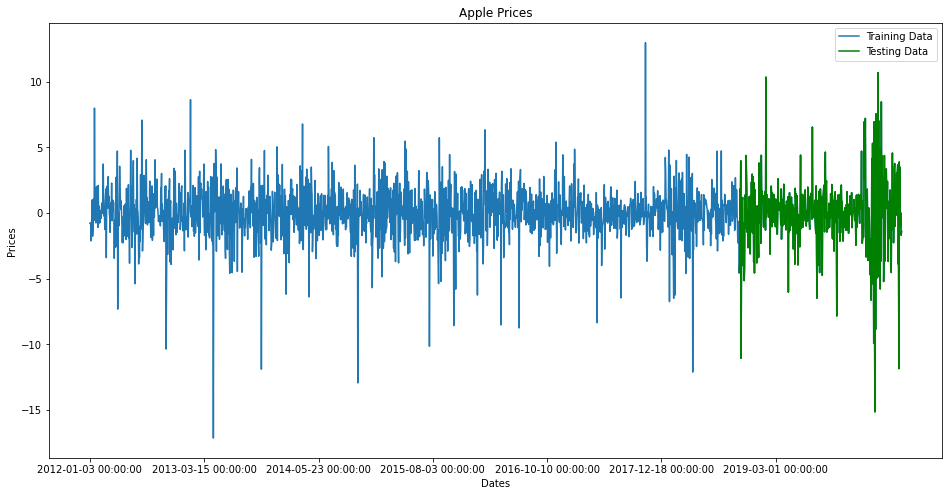

In [ ]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(16,8))
plt.title('Apple Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close_shift'], label='Training Data')
plt.plot(test_data['Close_shift'], 'green', label='Testing Data')
plt.xticks(np.arange(0,1857, 300), df['Date'][0:2000:300])
plt.legend()

In [ ]:
#p=1, d=0, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train_data['Close_shift'],order=(1,0,1))
#model=ARIMA(df['Close_shift'],order=(1,0,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Close_shift   No. Observations:                 1704
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3569.118
Date:                Mon, 07 Sep 2020   AIC                           7146.236
Time:                        14:25:56   BIC                           7167.998
Sample:                             0   HQIC                          7154.291
                               - 1704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0234      0.051     -0.460      0.645      -0.123       0.076
ar.L1         -0.6691      0.214     -3.127      0.002      -1.089      -0.250
ma.L1          0.7061      0.206      3.425      0.001       0.302       1.110
sigma2         3.8621      0.059     65.812      0.000       3.747       3.977
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              6020.24
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

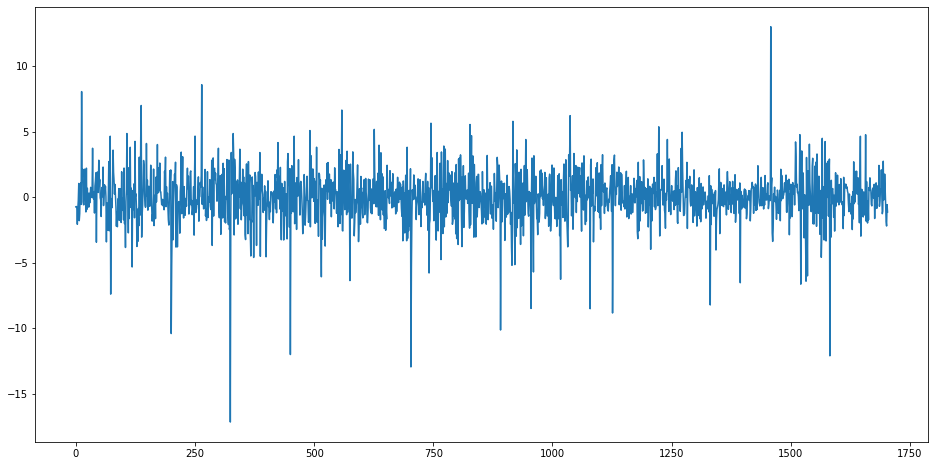

In [ ]:
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
plt.figure(figsize=(16,8))

plt.plot(residuals)

,0
count,1704.000000
mean,-0.000013
std,1.965814
min,-17.171493
25%,-0.956734
50%,0.011764
75%,1.020760
max,13.018742


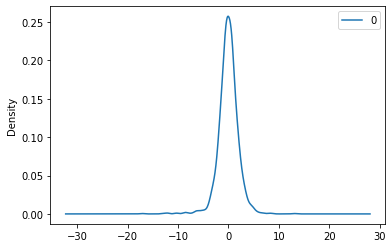

In [ ]:
#probabality distribution of residuals
#kde= kernel distribution estimate


residuals.plot(kind='kde')
residuals.describe()

In [ ]:
train_arima = train_data['Close']
test_arima = test_data['Close']
history = [x for x in train_arima]
print(type(history))
predictions = list()




for t in range(len(test_arima)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    #output = model_fit.predict(start=len(train_arima)+t-1, end = len(train_arima)+t,dynamic=True)
    output = model_fit.forecast(steps=10)
    yhat = output[0]
    predictions.append(yhat)
    obs = test_arima.iloc[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))





error = mean_squared_error(test_arima, predictions)
print('MSE : %.3f' % error)
error2 = math.sqrt(error)
print('RMSE : %.3f' % error2)

<class 'list'>
predicted=147.191158, expected=142.690002
predicted=142.554224, expected=139.020004
predicted=138.975825, expected=140.850006
predicted=140.951282, expected=141.130005
predicted=141.069924, expected=145.119995
predicted=145.313698, expected=134.050003
predicted=133.566670, expected=130.550003
predicted=130.798695, expected=129.100006
predicted=128.881161, expected=130.020004
predicted=130.199744, expected=131.210007
predicted=131.125090, expected=127.209999
predicted=127.136374, expected=126.449997
predicted=126.476802, expected=124.790001
predicted=124.712729, expected=119.639999
predicted=119.504721, expected=115.400002
predicted=115.332302, expected=115.430000
predicted=115.478382, expected=116.830002
predicted=116.850929, expected=115.669998
predicted=115.610720, expected=120.059998
predicted=120.267370, expected=123.120003
predicted=123.090947, expected=124.839996
predicted=124.928142, expected=123.379997
predicted=123.261323, expected=123.540001
predicted=123.62911

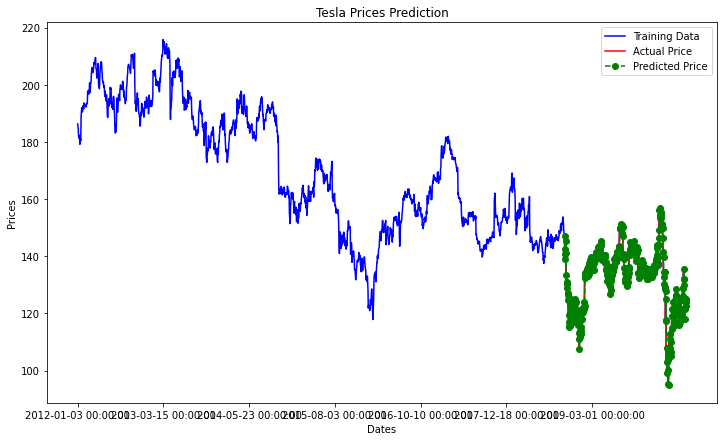

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
plt.legend()

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.6MB/s 
     |████████████████████████████████| 2.1MB 18.0MB/s 
     |████████████████████████████████| 8.7MB 30.7MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0


In [ ]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(train_arima, start_p=1, start_q=1, max_p=3, max_q=3, m=1,
                             start_P=0, seasonal=True, d=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7142.924, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7143.114, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7144.284, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7144.211, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7141.345, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.229 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1704
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3569.673
Date:                Mon, 07 Sep 2020   AIC                           7141.345
Time:                        14:28:53   BIC                           7146.785
Sample:                             0   HQIC                          7143.359
                               - 1704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.8742      0.057     68.343      0.000       3.763       3.985
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):              5888.96
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
apple_data=web.DataReader('IBM',data_source='yahoo',start='2012-01-01',end='2020-09-03')
train_arimas = apple_data['Close']
history = [x for x in train_arimas]
models=ARIMA(history,order=(1,1,1))
model_fits=models.fit()
forecasts=model_fits.forecast()[0]
print(forecasts)




124.5669574442625


In [ ]:
# # df=web.data.get_data_yahoo('INFY',start='2012-01-01' ,end='2020-06-22')
# # df= df.reset_index()

# # train_arima = df[:int(len(df)*0.8)]
# # test_arima = df[int(len(df)*0.8):]


# p_values = range(0,4)
# d_values = range(0,3)
# q_values = range(0,2)

# for p in p_values:
  
#   for d in d_values:
    
#     for q in q_values:
  
#       order = (p,d,q)
#       train_arima = train_data['Close']
#       test_arima = test_data['Close']
      
#       history = [x for x in train_arima]
#       print(type(history))
#       predictions = list()
      
#       print('Order=({},{},{})'.format(p,d,q))
#       for t in range(len(test_arima)):
#         model = ARIMA(history, order=order)
#         model_fit = model.fit()
#         #output = model_fit.predict(start=len(train_arima)+t-1, end = len(train_arima)+t,dynamic=True)
#         output = model_fit.forecast(steps=10)
#         yhat = output[0]
#         predictions.append(yhat)
#         obs = test_arima.iloc[t]
#         history.append(obs)
#         #print('predicted=%f, expected=%f' % (yhat, obs))
#       error = mean_squared_error(test_arima, predictions)
#       print('MSE : %.3f' % error)
#       error2 = math.sqrt(error)
#       print('RMSE : %.3f' % error2)
#       print(end='\n')

# <class 'list'>
# Order=(0,0,0)
# MSE : 6.358
# RMSE : 2.522
# <class 'list'>
# Order=(0,0,1)
# MSE : 1.766
# RMSE : 1.329
# <class 'list'>
# Order=(0,1,0)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(0,1,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(0,2,0)
# MSE : 0.089
# RMSE : 0.298
# <class 'list'>
# Order=(0,2,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(1,0,0)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(1,0,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(1,1,0)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(1,1,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(1,2,0)
# MSE : 0.058
# RMSE : 0.241
# <class 'list'>
# Order=(1,2,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(2,0,0)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(2,0,1)
# MSE : 11.080
# RMSE : 3.329
# <class 'list'>
# Order=(2,1,0)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(2,1,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(2,2,0)
# MSE : 0.055
# RMSE : 0.234
# <class 'list'>
# Order=(2,2,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(3,0,0)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(3,0,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(3,1,0)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(3,1,1)
# MSE : 0.042
# RMSE : 0.205
# <class 'list'>
# Order=(3,2,0)
# MSE : 0.054
# RMSE : 0.232
# <class 'list'>
# Order=(3,2,1)
# MSE : 0.042
# RMSE : 0.205